In [39]:
# Mount drive
import os
from google.colab import drive
from google.colab import files

drive_mount_point = '/content/drive/'
drive.mount(drive_mount_point)

%cd ./drive/MyDrive/AA273/HW6/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[Errno 2] No such file or directory: './drive/MyDrive/AA273/HW6/'
/content/drive/MyDrive/AA273/HW6


# Problem 1
## (a)
Denote the state $x = \begin{bmatrix} p_t \\ s_t \end{bmatrix} \in \mathbb{R}^4$. We can rewrite the dynamics as
$$\begin{align}
    x_{t+1} =& \begin{bmatrix} I & \delta t I \\ 0 & I \end{bmatrix} x_t + \begin{bmatrix} 0 \\ \delta t I\end{bmatrix} u_t + \begin{bmatrix} 0 \\ W_t \end{bmatrix} \\
    y_t =& \begin{bmatrix} I & 0 \end{bmatrix} x_t + V_t
\end{align}$$

By observation, we know
$$A = \begin{bmatrix} I & \delta t I \\ 0 & I \end{bmatrix} \quad B = \begin{bmatrix} 0 \\ \delta t I\end{bmatrix} \quad C = \begin{bmatrix} I & 0 \end{bmatrix}$$

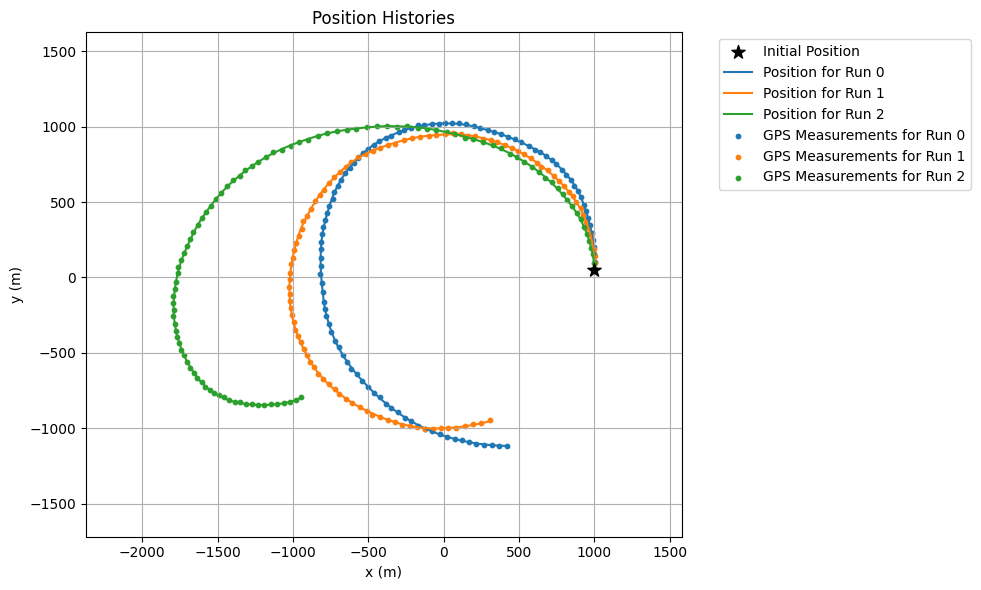

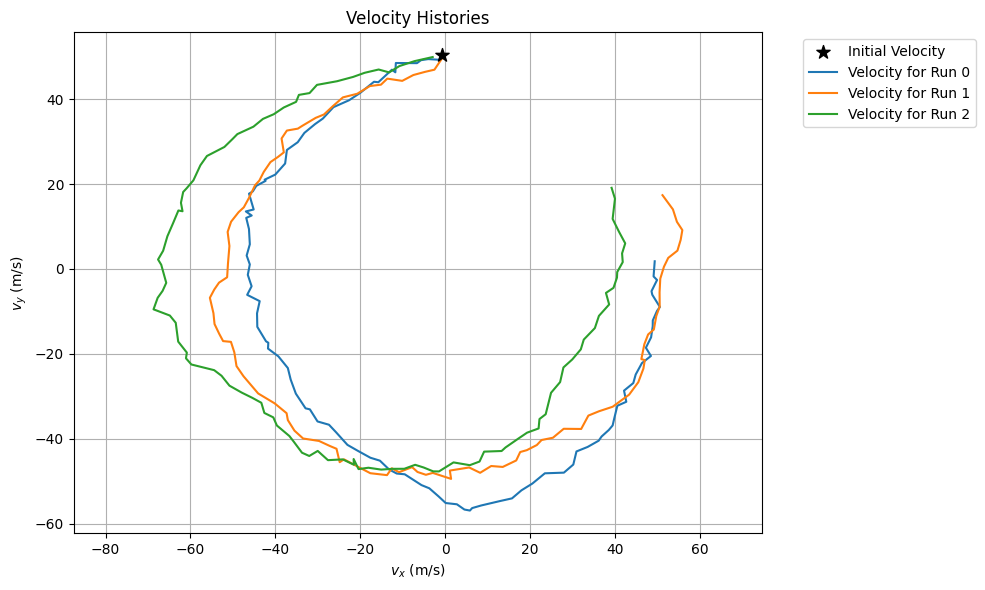

In [40]:
# (b)
import numpy as np
import matplotlib.pyplot as plt
import q1q2_simulator_class as sim

# Define the parameters
n_steps = 100
p0 = [1000, 0]
s0 = [0, 50]

# Initialize the simulator
quadrotor = sim.QuadrotorSimulator(sensor="GPS")

prun_hists, srun_hists, yrun_hists, urun_hists = quadrotor.simulate_multiple_runs(p0, s0, n_steps, num_runs=3)

fig1b1 = quadrotor.plot_position_histories(prun_hists, yrun_hists)
fig1b2 = quadrotor.plot_velocity_histories(srun_hists)

In [41]:
# (c)
mu0 = np.array([1500, 100, 0, 55])
sig0 = np.block([[250000*np.eye(2), np.zeros((2,2))], [np.zeros((2,2)), np.eye(2)]])

dt = 1
A = np.block([[np.eye(2), dt * np.eye(2)],
              [np.zeros((2,2)), np.eye(2)]])
B = np.block([[np.zeros((2,2))], [dt*np.eye(2)]])
C = np.block([np.eye(2), np.zeros((2,2))])
Q = np.block([[np.zeros((2,2)), np.zeros((2,2))], [np.zeros((2,2)), np.eye(2)]])
R = 9 * np.eye(2)

prun_hist, srun_hist, yrun_hist, urun_hist = quadrotor.simulate(p0, s0, n_steps)

mu_pred = np.zeros((prun_hist.shape[0] + 1, (prun_hist.shape[1]+srun_hist.shape[1]))) # (101,4)
sig_pred = np.zeros((prun_hist.shape[0] + 1, prun_hist.shape[1]*2, prun_hist.shape[1]*2)) # (101, 4, 4)

mu_update = np.zeros_like(mu_pred)
sig_update = np.zeros_like(sig_pred)

# print(mu_pred.shape)
# print(sig_pred.shape)

# initial predict/update
mu_pred[0, :] = mu0
sig_pred[0, ...] = sig0
mu_update[0, :] = mu0
sig_update[0, ...] = sig0

# Kalman filter
for t in range(1, n_steps+1):
    # predict
    mp = A @ mu_update[t-1, :] + B @ urun_hist[t-1]
    sp = A @ sig_update[t-1, ...] @ A.T + Q
    # update
    # K = np.transpose( np.linalg.solve( np.transpose(C @ sp @ C.T + R), np.transpose(sp @ C.T)) )
    K = sp @ C.T @ np.linalg.inv( C @ sp @ C.T + R )
    # print(np.linalg.inv( C @ sp @ C.T + R ))
    # print(K)
    mu = mp + K @ (yrun_hist[t-1] - C @ mp)
    su = sp - K @ C @ sp
    # print(K @ C, K @ C @ sp)
    # print(sp, '\n')

    # record
    mu_pred[t, :] = mp
    sig_pred[t, ...] = sp
    mu_update[t, :] = mu
    sig_update[t, ...] = su

In [80]:
import scipy
from scipy.stats import chi2

def error_ellipse(ax, mu, sig, p=0.95, to_sample=False, samples=1000):
    # Ellipse
    t = np.linspace(0, 2*np.pi, 100)
    circ = np.array([np.cos(t), np.sin(t)]).T
    # calculate stretch
    r = chi2.ppf(p, df=2)
    eta = scipy.linalg.sqrtm(sig) * np.sqrt(r)
    ellipse = circ @ eta + mu

    # Draw
    ax.plot(ellipse[:,0], ellipse[:,1], color='k', alpha=0.2, label="Error ellipses")
    if to_sample:
        # Sample
        pts = np.random.multivariate_normal(mu, sig, size=samples)
        ax.scatter(pts[:,0], pts[:,1], color='b',alpha=0.2)

        # calculate portion
        is_inner = ((pts-mu) @ np.linalg.inv(sig) @ (pts-mu).T).diagonal() <= r
        return np.mean(is_inner)

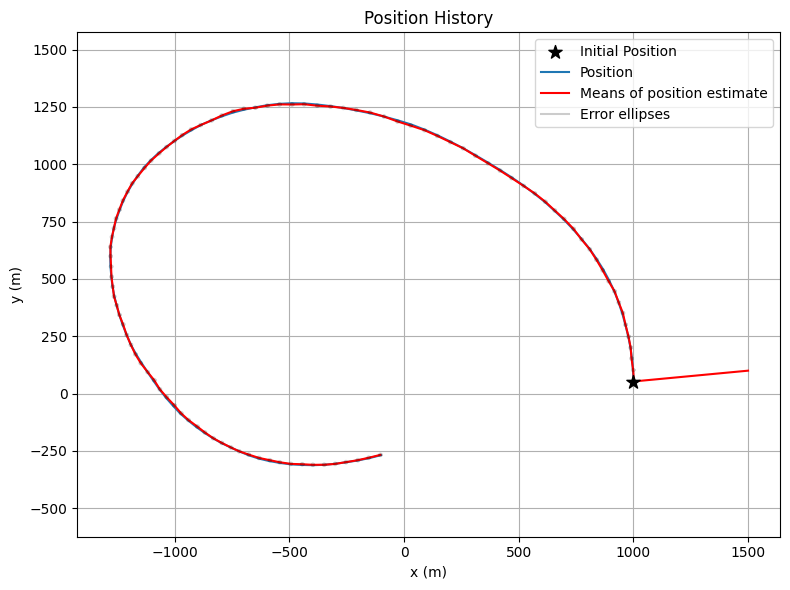

In [43]:
fig1c1 = quadrotor.plot_position_history(prun_hist, show_plot=False)
ax = fig1c1.axes[0]
ax.plot(mu_update[:,0], mu_update[:,1], color='r', label="Means of position estimate")
for t in range(1, mu_update.shape[0]):
    m = mu_update[t, :2]
    s = sig_update[t, :2, :2]
    error_ellipse(ax, m, s)

handles, legends = ax.get_legend_handles_labels()
plt.legend(handles[:4], legends[:4])
plt.show()

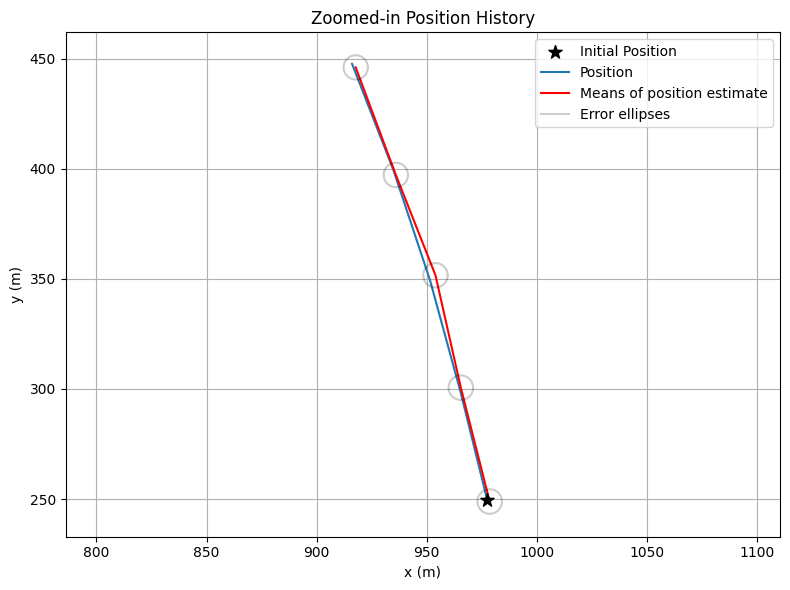

In [44]:
fig1c2 = quadrotor.plot_position_history(prun_hist[4:9], show_plot=False)
ax = fig1c2.axes[0]
ax.plot(mu_update[5:10,0], mu_update[5:10,1], color='r', label="Means of position estimate")
for t in range(5, 10):
    m = mu_update[t, :2]
    s = sig_update[t, :2, :2]
    error_ellipse(ax, m, s)

handles, legends = ax.get_legend_handles_labels()
plt.legend(handles[:4], legends[:4])
plt.title("Zoomed-in Position History")
plt.show()

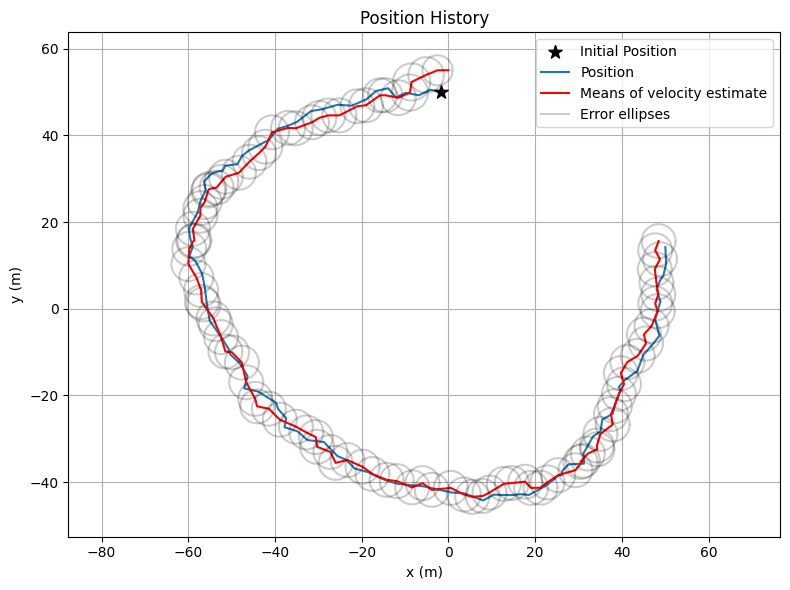

In [45]:
# (d)
fig1d1 = quadrotor.plot_position_history(srun_hist, show_plot=False)
ax = fig1d1.axes[0]
ax.plot(mu_update[:,2], mu_update[:,3], color='r', label="Means of velocity estimate")
for t in range(1, mu_update.shape[0]):
    m = mu_update[t, 2:]
    s = sig_update[t, 2:, 2:]
    error_ellipse(ax, m, s)

handles, legends = ax.get_legend_handles_labels()
plt.legend(handles[:4], legends[:4])
plt.show()

# Problem 2
Denote the state $x = \begin{bmatrix} p_t \\ s_t \end{bmatrix} \in \mathbb{R}^4$. We can rewrite the dynamics as
$$\begin{align}
    x_{t+1} =& \begin{bmatrix} I & \delta t I \\ 0 & I \end{bmatrix} x_t + \begin{bmatrix} 0 \\ \delta t I\end{bmatrix} u_t + \begin{bmatrix} 0 \\ W_t \end{bmatrix} \\
    y_t =& \begin{bmatrix} 0 & I \end{bmatrix} x_t + V_t
\end{align}$$

By observation, we know
$$A = \begin{bmatrix} I & \delta t I \\ 0 & I \end{bmatrix} \quad B = \begin{bmatrix} 0 \\ \delta t I\end{bmatrix} \quad C = \begin{bmatrix} 0 & I \end{bmatrix}$$

In [46]:
# Initialize the simulator
quadrotor = sim.QuadrotorSimulator(sensor="Velocity")

mu0 = np.array([1000, 0, 0, 50])
sig0 = np.block([[np.eye(2), np.zeros((2,2))], [np.zeros((2,2)), np.eye(2)]])

dt = 1
A = np.block([[np.eye(2), dt * np.eye(2)],
              [np.zeros((2,2)), np.eye(2)]])
B = np.block([[np.zeros((2,2))], [dt*np.eye(2)]])
C = np.block([np.zeros((2,2)), np.eye(2)])
Q = np.block([[np.zeros((2,2)), np.zeros((2,2))], [np.zeros((2,2)), np.eye(2)]])
R = 9 * np.eye(2)

prun_hist, srun_hist, yrun_hist, urun_hist = quadrotor.simulate(p0, s0, n_steps)

mu_pred = np.zeros((prun_hist.shape[0] + 1, (prun_hist.shape[1]+srun_hist.shape[1]))) # (101,4)
sig_pred = np.zeros((prun_hist.shape[0] + 1, prun_hist.shape[1]*2, prun_hist.shape[1]*2)) # (101, 4, 4)

mu_update = np.zeros_like(mu_pred)
sig_update = np.zeros_like(sig_pred)

# print(mu_pred.shape)
# print(sig_pred.shape)

# initial predict/update
mu_pred[0, :] = mu0
sig_pred[0, ...] = sig0
mu_update[0, :] = mu0
sig_update[0, ...] = sig0

# Kalman filter
for t in range(1, n_steps+1):
    # predict
    mp = A @ mu_update[t-1, :] + B @ urun_hist[t-1]
    sp = A @ sig_update[t-1, ...] @ A.T + Q
    # update
    K = np.transpose( np.linalg.solve( np.transpose(C @ sp @ C.T + R), np.transpose(sp @ C.T)) )
    mu = mp + K @ (yrun_hist[t-1] - C @ mp)
    su = sp - K @ C @ sp

    # record
    mu_pred[t, :] = mp
    sig_pred[t, ...] = sp
    mu_update[t, :] = mu
    sig_update[t, ...] = su

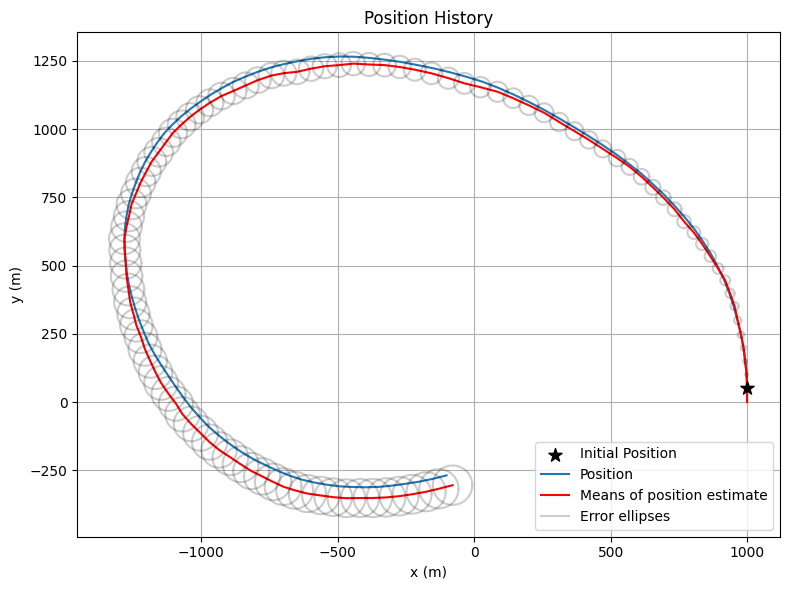

In [47]:
fig21 = quadrotor.plot_position_history(prun_hist, show_plot=False)
ax = fig21.axes[0]
ax.plot(mu_update[:,0], mu_update[:,1], color='r', label="Means of position estimate")
for t in range(1, mu_update.shape[0]):
    m = mu_update[t, :2]
    s = sig_update[t, :2, :2]
    error_ellipse(ax, m, s)

handles, legends = ax.get_legend_handles_labels()
plt.legend(handles[:4], legends[:4])
plt.show()

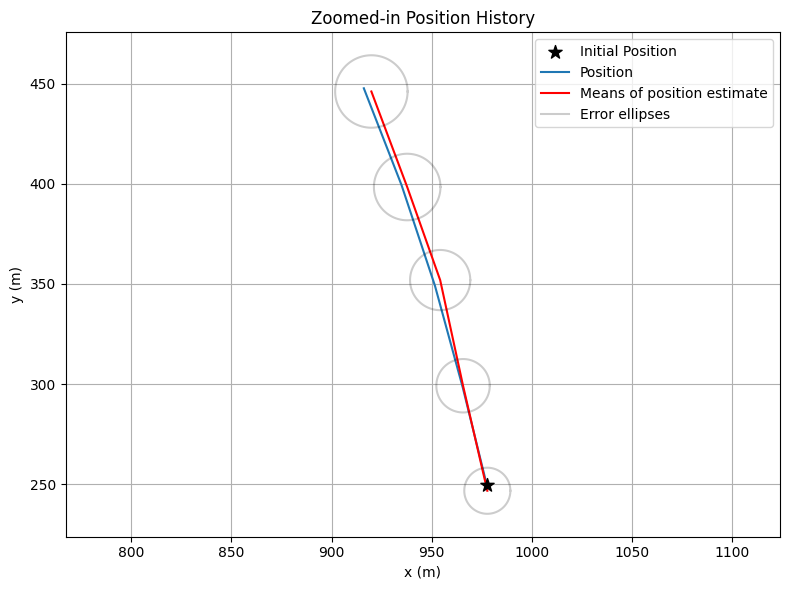

In [48]:
fig22 = quadrotor.plot_position_history(prun_hist[4:9], show_plot=False)
ax = fig22.axes[0]
ax.plot(mu_update[5:10,0], mu_update[5:10,1], color='r', label="Means of position estimate")
for t in range(5, 10):
    m = mu_update[t, :2]
    s = sig_update[t, :2, :2]
    error_ellipse(ax, m, s)

handles, legends = ax.get_legend_handles_labels()
plt.legend(handles[:4], legends[:4])
plt.title("Zoomed-in Position History")
plt.show()

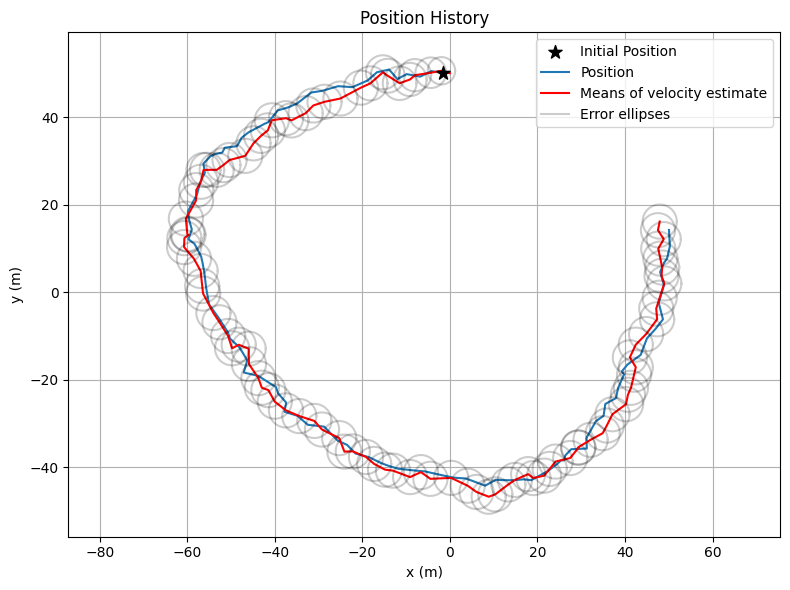

In [49]:
fig23 = quadrotor.plot_position_history(srun_hist, show_plot=False)
ax = fig23.axes[0]
ax.plot(mu_update[:,2], mu_update[:,3], color='r', label="Means of velocity estimate")
for t in range(1, mu_update.shape[0]):
    m = mu_update[t, 2:]
    s = sig_update[t, 2:, 2:]
    error_ellipse(ax, m, s)

handles, legends = ax.get_legend_handles_labels()
plt.legend(handles[:4], legends[:4])
plt.show()

# Problem 3
Denote $X_t = [P_t^x, P_t^y, \Theta_t]^T$ and $U_t = [s_t, \phi_t]^T$,
$$\begin{align}
    X_{t+1} = f(X_t, U_t) + W_t \\
    A_t = \frac{\partial}{\partial X_t} f(X_t, U_t) |_{X_t = \mu_{t-1, est}} = \begin{bmatrix}
        1 & 0 & -\delta t s_{t-1} \sin \Theta_{t-1} \\
        0 & 1 & \delta t s_{t-1} \cos \Theta_{t-1} \\
        0 & 0 & 1
    \end{bmatrix}_{X_t = \mu_{t-1, est}}
\end{align}$$

Denote the measurement model:
$$\begin{align}
Y_t = \begin{bmatrix} ||p_t - p_1|| + v_t \\ ||p_t - p_2|| + v_t \end{bmatrix} = \begin{bmatrix} \sqrt{(p_t - p_1)^T(p_t - p_1)} + v_t \\ \sqrt{(p_t - p_2)^T(p_t - p_2)} + v_t\end{bmatrix} = \begin{bmatrix} \sqrt{p_t^Tp_t - 2p_1^Tp_t + p_1^Tp_1} + v_t \\ \sqrt{p_t^Tp_t - 2p_2^Tp_t + p_2^Tp_2} + v_t\end{bmatrix} = g(x_t) + V_t \\
C_t = \frac{\partial}{\partial X_t} g(X_t) |_{X_t = \mu_{pred}} = \begin{bmatrix}
    \frac{2p_t - 2p_1}{2\sqrt{p_t^Tp_t - 2p_1^Tp_t + p_1^Tp_1}} & 0 \\
    \frac{2p_t - 2p_2}{2\sqrt{p_t^Tp_t - 2p_2^Tp_t + p_2^Tp_2}} & 0
\end{bmatrix} \in \mathbb{R}^{2\times 3}
\end{align}$$

In [94]:
import q3_simulator_class as sim
from sklearn.preprocessing import normalize
import time

n_steps = 100
pose0 = [0, 0, 0]
p_1 = np.array([30, -5])
p_2 = np.array([-10, 20])

robot = sim.MobileRobotSimulator()

dt = 0.5

At = lambda mu, st: np.array([[1, 0, -dt * st * np.sin(mu[2])],
                              [0, 1,  dt * st * np.cos(mu[2])],
                              [0, 0, 1]])
Ct = lambda mu: np.block([[(mu[:2] - p_1) / np.sqrt(np.sum((mu[:2] - p_1) ** 2)), 0],
                          [(mu[:2] - p_2) / np.sqrt(np.sum((mu[:2] - p_2) ** 2)), 0]])

Q = 0.1 * dt * np.eye(3)
R = 0.1 * np.eye(2)

s_t = 1
phi_t = lambda t: np.sin(t)

mu0 = np.array([0, 0, 0])
sig0 = 0.01 * np.eye(3)


prun_hist, yrun_hist, urun_hist = robot.simulate(pose0, n_steps)

In [95]:
# (a) EKF
mu_pred_EKF = np.zeros((n_steps + 1, mu0.shape[0])) # (101,3)
sig_pred_EKF = np.zeros((n_steps + 1, sig0.shape[0], sig0.shape[0])) # (303, 3)

mu_update_EKF = np.zeros_like(mu_pred_EKF)
sig_update_EKF = np.zeros_like(sig_pred_EKF)

# initial predict/update
mu_pred_EKF[0, :] = mu0
sig_pred_EKF[0, ...] = sig0
mu_update_EKF[0, :] = mu0
sig_update_EKF[0, ...] = sig0

A_hist = np.zeros((n_steps, 3, 3))
C_hist = np.zeros((n_steps, 2, 3))

# timer
timestamps_EKF = np.zeros((n_steps+1,))
timestamps_EKF[0] = time.time()

# Extended Kalman filter
for t in range(1, n_steps+1):
    # time-variant parameter
    A = At(mu_update_EKF[t-1, :], urun_hist[t-1,0])
    mp, _ = robot.noiseless_dynamics_step(mu_update_EKF[t-1, :], t=t-1)
    C = Ct(mp)

    # predict
    sp = A @ sig_update_EKF[t-1, ...] @ A.T + Q

    # update
    K = np.transpose( np.linalg.solve( np.transpose(C @ sp @ C.T + R), np.transpose(sp @ C.T)) )
    # K = sp @ C.T @ np.linalg.inv( C @ sp @ C.T + R )
    mu = mp + K @ (yrun_hist[t-1] - robot.noiseless_measurement_step(mp))
    su = sp - K @ C @ sp

    # record
    mu_pred_EKF[t, :] = mp
    sig_pred_EKF[t, ...] = sp
    mu_update_EKF[t, :] = mu
    sig_update_EKF[t, ...] = su
    A_hist[t-1, ...] = A
    C_hist[t-1, ...] = C

    # timer
    timestamps_EKF[t] = time.time()

$$
\begin{align}
W_O(t_0,t_f) = \int_{t_0}^{t_f} \Phi^T(\tau, t_0)C^T(t)C(t)\Phi(\tau,t_0)d\tau \\
\approx \sum_{\tau = t_0}^{t_f}\Phi^T(\tau, t_0)C^T(t)C(t)\Phi(\tau,t_0) \Delta \tau
\end{align}$$
$$\begin{align}
\Phi(t, t_0) = \exp \int_{t_0}^t A(\tau)d\tau \\
\approx \exp \big[\sum_{\tau = t_0}^t A(\tau)\delta \tau\big]
\end{align}$$

In [97]:
# Check observability by finding the observability gramian
from scipy.linalg import expm
Wo = np.zeros((n_steps, 3, 3))
for t in range(n_steps):
    phi = expm(np.sum(A_hist[:(t+1), ...] * dt, axis=0))
    Wo_unit = phi.T @ C_hist[t, ...].T @ C_hist[t, ...] @ phi
    Wo[t, ...] = Wo_unit + np.sum(Wo[:t, ...], axis=0)
    print("The rank of the observable gramian at {} steps: ".format(t), np.linalg.matrix_rank(Wo[t, ...]))

The rank of the observable gramian at 0 steps:  2
The rank of the observable gramian at 1 steps:  3
The rank of the observable gramian at 2 steps:  3
The rank of the observable gramian at 3 steps:  3
The rank of the observable gramian at 4 steps:  3
The rank of the observable gramian at 5 steps:  3
The rank of the observable gramian at 6 steps:  3
The rank of the observable gramian at 7 steps:  3
The rank of the observable gramian at 8 steps:  3
The rank of the observable gramian at 9 steps:  3
The rank of the observable gramian at 10 steps:  3
The rank of the observable gramian at 11 steps:  3
The rank of the observable gramian at 12 steps:  3
The rank of the observable gramian at 13 steps:  3
The rank of the observable gramian at 14 steps:  3
The rank of the observable gramian at 15 steps:  3
The rank of the observable gramian at 16 steps:  3
The rank of the observable gramian at 17 steps:  3
The rank of the observable gramian at 18 steps:  3
The rank of the observable gramian at 19 

Therefore, the linearized system is sometimes observable. It is observable after three steps.

In [78]:
# (b) UKF
from scipy.linalg import sqrtm
mu_pred_UKF = np.zeros((n_steps + 1, mu0.shape[0])) # (101,3)
sig_pred_UKF = np.zeros((n_steps + 1, sig0.shape[0], sig0.shape[0])) # (303, 3)

mu_update_UKF = np.zeros_like(mu_pred_UKF)
sig_update_UKF = np.zeros_like(sig_pred_UKF)

# initial predict/update
mu_pred_UKF[0, :] = mu0
sig_pred_UKF[0, ...] = sig0
mu_update_UKF[0, :] = mu0
sig_update_UKF[0, ...] = sig0

def UT(mean, cov, lam=2):
    n = cov.shape[0]
    L = np.sqrt(lam+n) * sqrtm(cov)

    x = np.tile(mean, (2*n + 1, 1))
    w = lam / (lam + n) * np.ones((2*n + 1, 1))
    for i in range(1, n+1):
        x[i] += L[:, i-1]
        w[i] = 1 / (2 * (lam + n))
        x[i+n] -= L[:, i-1]
        w[i+n] = 1 / (2 * (lam + n))
    # print("x: ", x)
    # print("w: ", w)
    return x, w

def compute_cov(vec, mean, w):
    return (vec-mean).T @ (w * (vec-mean))

def UTinv(x, w):
    mean = np.sum(w * x, axis=0)
    cov  = (x-mean).T @ (w * (x-mean))
    return mean, cov

# timer
timestamps_UKF = np.zeros((n_steps+1,))
timestamps_UKF[0] = time.time()

# Unscented Kalman filter
for t in range(1, n_steps+1):
    # predict
    x_pred, w_pred = UT(mu_update_UKF[t-1, :], sig_update_UKF[t-1, ...])
    x_pred_ = np.copy(x_pred)
    for i in range(x_pred_.shape[0]):
        x_pred_[i], _ = robot.noiseless_dynamics_step(x_pred[i], t=t-1)
    mp, sp = UTinv(x_pred_, w_pred)
    sp += Q

    # update
    x_update, w_update = UT(mp, sp)
    y_pred = np.zeros((x_update.shape[0], 2))
    for i in range(y_pred.shape[0]):
        y_pred[i] = robot.noiseless_measurement_step(x_update[i])
    y_exp, Sig_y = UTinv(y_pred, w_update)
    Sig_y += R
    Sig_xy = (x_update - mp).T @ (w_update * (y_pred - y_exp))

    Sig_xySig_y_inv = np.transpose( np.linalg.solve(Sig_y.T, Sig_xy.T) )
    mu = mp + Sig_xySig_y_inv @ (yrun_hist[t-1] - y_exp)
    su = sp - Sig_xySig_y_inv @ Sig_xy.T
    # mu = mp + Sig_xy @ np.linalg.inv(Sig_y) @ (yrun_hist[t-1] - y_exp)
    # su = sp - Sig_xy @ np.linalg.inv(Sig_y) @ Sig_xy.T

    # record
    mu_pred_UKF[t, :] = mp
    sig_pred_UKF[t, ...] = sp
    mu_update_UKF[t, :] = mu
    sig_update_UKF[t, ...] = su
    # print("mu: ", mu)
    # print("su: ", su)

    # timer
    timestamps_UKF[t] = time.time()

In [54]:
# (c) PF
np.random.seed(273)
N_particles = 1000
p_hist = np.zeros((n_steps+1, N_particles, mu0.shape[0]))
p0 = np.random.multivariate_normal(mu0, sig0, (N_particles,))
w = 1/N_particles * np.ones((N_particles,))
p_hist[0, :, :] = p0

pYX = lambda y, x: np.exp(-0.5 * (y - robot.noiseless_measurement_step(x)).T @ np.linalg.solve(R, (y - robot.noiseless_measurement_step(x))) )

# print(p_hist.shape, p0.shape)

# timer
timestamps_PF = np.zeros((n_steps+1,))
timestamps_PF[0] = time.time()

# Particle Filter
for t in range(1, n_steps+1):
    # predict
    p_pred = np.zeros_like(p0)
    w_pred = np.zeros_like(w)
    for i in range(p_hist.shape[0]):
        x, u = robot.noisy_dynamics_step(p_hist[t-1, i, :], t=t-1)
        p_pred[i, :] = x
        w_pred[i] = pYX(yrun_hist[t-1], x)
    # update
    w = w_pred / np.sum(w_pred)

    # importance re-sampling
    idx_array = np.arange(p_pred.shape[0])
    idx_mask = np.random.choice(idx_array, size=p_pred.shape[0], p=w)
    p_hist[t, :, :] = p_pred[idx_mask]
    w = 1/N_particles * np.ones((N_particles,))

    # timer
    timestamps_PF[t] = time.time()

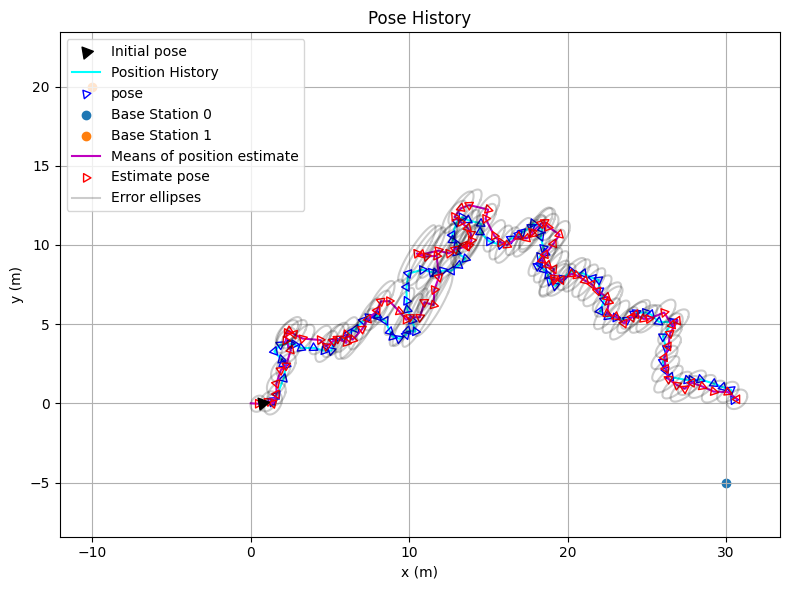

In [96]:
# (d)

# EKF
fig3d1 = robot.plot_pose_history(prun_hist, show_plot=False)
ax = fig3d1.axes[0]
ax.plot(mu_update_EKF[:,0], mu_update_EKF[:,1], color='m', label="Means of position estimate")
for t in range(1, mu_update.shape[0]):
    m = mu_update_EKF[t, :2]
    s = sig_update_EKF[t, :2, :2]
    plt.scatter(m[0], m[1], facecolors='none', s=50, zorder=2, edgecolors='red',
                marker=(3, 0, -90 + np.rad2deg(mu_update_EKF[t,2])), label="Estimate pose")
    error_ellipse(ax, m, s)

handles, legends = ax.get_legend_handles_labels()
plt.legend(handles[:8], legends[:8])
plt.show()

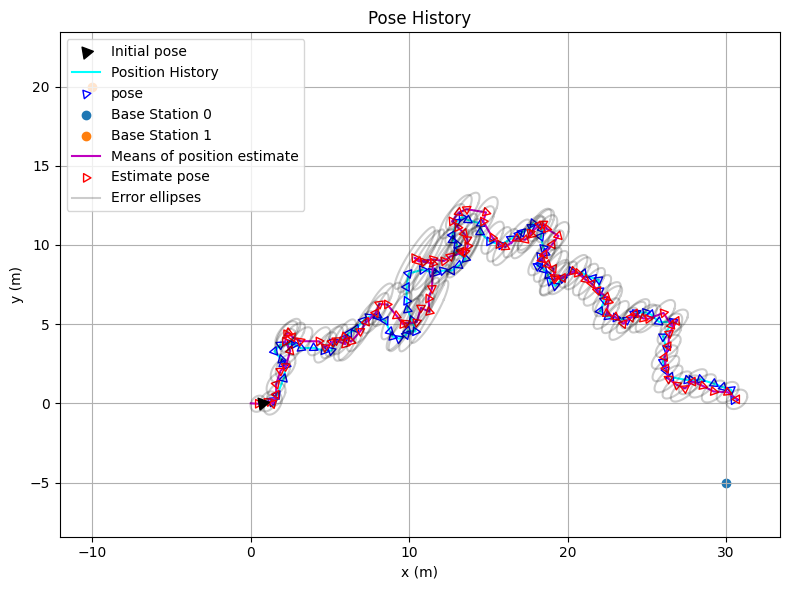

In [79]:
# UKF
fig3d2 = robot.plot_pose_history(prun_hist, show_plot=False)
ax = fig3d2.axes[0]
ax.plot(mu_update_UKF[:,0], mu_update_UKF[:,1], color='m', label="Means of position estimate")
for t in range(1, mu_update.shape[0]):
    m = mu_update_UKF[t, :2]
    s = sig_update_UKF[t, :2, :2]
    plt.scatter(m[0], m[1], facecolors='none', s=50, zorder=2, edgecolors='red',
                marker=(3, 0, -90 + np.rad2deg(mu_update_UKF[t,2])), label="Estimate pose")
    error_ellipse(ax, m, s)

handles, legends = ax.get_legend_handles_labels()
plt.legend(handles[:8], legends[:8])
plt.show()

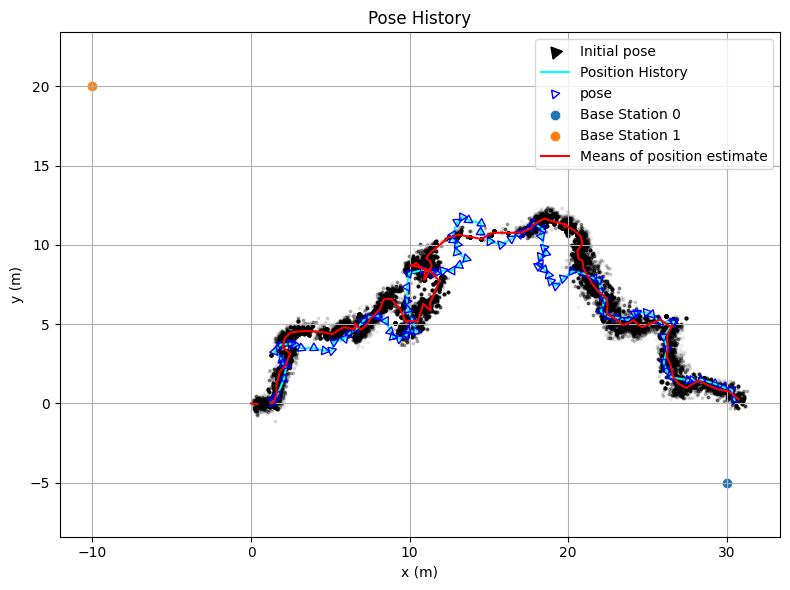

In [57]:
# PF
mu_update_PF = np.mean(p_hist, axis=1)
fig3d3 = robot.plot_pose_history(prun_hist, show_plot=False)
ax = fig3d3.axes[0]
ax.plot(mu_update_PF[:,0], mu_update_PF[:,1], color='r', label="Means of position estimate")
for t in range(1, mu_update.shape[0]):
    plt.scatter(p_hist[t, :, 0], p_hist[t, :, 1], color='k', alpha=0.05, s=3)

handles, legends = ax.get_legend_handles_labels()
plt.legend(handles[:8], legends[:8])
plt.show()

Comment:

In [58]:
# (e)
EKF_avg_time = np.mean(np.diff(timestamps_EKF))
print("The average computation time for one loop of EKF: ", EKF_avg_time*1000, "milliseconds.")
UKF_avg_time = np.mean(np.diff(timestamps_UKF))
print("The average computation time for one loop of UKF: ", UKF_avg_time*1000, "milliseconds.")
PF_avg_time = np.mean(np.diff(timestamps_PF))
print("The average computation time for one loop of PF: ", PF_avg_time*1000, "milliseconds.")

The average computation time for one loop of EKF:  0.8295321464538574 milliseconds.
The average computation time for one loop of UKF:  6.992428302764893 milliseconds.
The average computation time for one loop of PF:  71.19221210479736 milliseconds.


EKF takes the least average computation time for one loop while the PF takes the most average computation time. UKF the medium performance. The result is reasonble as the computation time is dependent on the magnitude of samples the algorithm requires to rollout. PF has every particles need to be rolled out while EKF only has a model-based rollout.